# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга**.

## 1. Первичный анализ данных

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords
from collections import Counter
import numpy as np

In [84]:
df = pd.read_csv('/datasets/data.csv')
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [86]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

**Вывод**

В таблице 12 столбцов. Тип данных во всех столбцах представлен в методе df.info() ('int64', 'object', 'float64').

В названиях колонок нет нарушения стиля. Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

 Явные пропуски встречаются в столбцах 'days_employed'(общий трудовой стаж в днях) и 'total_income'(ежемесячный доход). Значение в признаке 'education'(уровень образования клиента) и 'family_status'(семейное положение) необходимо привести к строчным символам. Значения в признаке 'days_employed'(общий трудовой стаж в днях) встречаются отрицательные. Значение в признаке 'purpose'(цель получения кредита) для упрощения анализа необходимо привести к одному слову и лемматизировать.
 
 Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но нужно провести подготовку данных к анализу.

## 2. Предобработка данных

### Обработка пропусков

In [87]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [88]:
na_percent = df['days_employed'].isna().sum()/df.shape[0]
print(f'Процент пропусков от всего датафрейма: {na_percent*100:.1f}%')

Процент пропусков от всего датафрейма: 10.1%


In [89]:
df['total_income'] = df['total_income']. \
fillna(df.groupby('income_type')['total_income']. \
       transform('median'))
df['days_employed'] = df['days_employed']. \
fillna(df.groupby('income_type')['days_employed']. \
       transform('median'))

In [90]:
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

<div class="alert alert-info">
    Заполнил пропуски медианными значениями групп ('income_type')

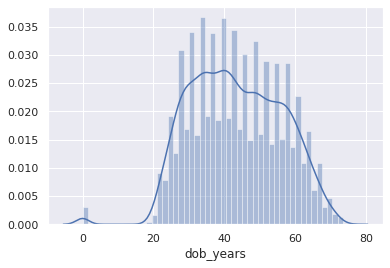

In [91]:
sns.distplot(df['dob_years'])

In [92]:
df.query('dob_years==0')['dob_years'].count()

101

In [93]:
df = df[df['dob_years']!=0]

In [94]:
df.query('dob_years==0')['dob_years'].count()

0

<div class="alert alert-info"> 
    Удалил нулевые значения

In [95]:
df['children'].value_counts()

 0     14080
 1      4802
 2      2042
 3       328
 20       75
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [96]:
df[(df['children']==-1)|(df['children']==20)]['children'].value_counts()

 20    75
-1     47
Name: children, dtype: int64

In [97]:
df = df[(df['children']!=-1)&(df['children']!=20)]

In [98]:
df[(df['children']==-1)|(df['children']==20)]['children']

Series([], Name: children, dtype: int64)

In [99]:
len(df)

21302

<div class="alert alert-info">
Значений мало, удалил из выборки

In [100]:
df[df['days_employed']<0].shape

(17481, 12)

In [101]:
df['days_employed'] = df['days_employed'].abs()

In [102]:
df[df['days_employed']<0].shape

(0, 12)

<div class = 'alert alert-info'>
    Привел все значения к положительным

In [103]:
df.query('(days_employed/365)-16>dob_years')['days_employed'].count()

3821

In [104]:
df.loc[(df["days_employed"]/365) > df['dob_years'], 'days_employed'] \
= df["days_employed"]/24

In [105]:
df.query('(days_employed/365)-16>dob_years')['days_employed']

1242     13948.510826
3619     15217.221094
12507    15812.170938
13953    15701.024409
19439    16224.881982
Name: days_employed, dtype: float64

In [106]:
df.drop([1242,3619,12507,13953,19439], inplace=True)

In [107]:
df.query('(days_employed/365)-16>dob_years')['days_employed']
len(df)

21297

<div class='alert alert-info'>
    Привел выбивающиеся значения к дням, 5 строк удалил, это скорее всего выбросы.

**Вывод**

Пропуски встречаются в столбцах 'days_employed'(общий трудовой стаж в днях) и 'total_income'(ежемесячный доход). Процент явных пропусков от всего датафрейма - 10,1%. Эти пропуски скорее носят MCAR (Missing Completely At Random) характер. Эти строки заменены на медианные значения по группам('income_type').

В признаке 'days_employed'(общий трудовой стаж в днях) встречаются отрицательные и превышающие возраст клиента значения. В сумме они составляют ориентировочно 20% от оставшегося датасета. Большие значения приведены из часов к дням. Отрицательные значения приведены к положительным. Выбросы с неправдоподобным колличеством детей и нулевым возростом клиентов удалены из датасета.

### Замена типа данных

In [108]:
df['total_income']=df['total_income'].astype('int')
df['days_employed']=df['days_employed'].astype('int')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Для простоты анализа приведем признак 'total_income' и 'days_employed' к типу 'int'.

<div class='alarm alarm-info'>
    Признак 'days_employed' приведен к целому значению

### Обработка дубликатов

In [109]:
df.duplicated().sum()

54

In [110]:
df['education'] = df['education'].str.lower()
df['family_status'] = df['family_status'].str.lower()

In [111]:
display(df.groupby(['education','education_id'], as_index=False)['income_type'].count())
display(df.groupby(['family_status','family_status_id'], as_index=False)['income_type'].count())

,education,education_id,income_type
0,высшее,0,5201
1,начальное,3,282
2,неоконченное высшее,2,739
3,среднее,1,15069
4,ученая степень,4,6


,family_status,family_status_id,income_type
0,в разводе,3,1178
1,вдовец / вдова,2,947
2,гражданский брак,1,4139
3,женат / замужем,0,12252
4,не женат / не замужем,4,2781


**Вывод**

Явных дубликатов нет. Из-за написания заглавными буквами значений признаков 'education' и 'family_status', возникали дублирующие категории, что затрудняло анализ данных.

### Лемматизация

In [112]:
purpose_list = list(df['purpose'].unique())
words=[]
for item in purpose_list:
    words += item.split()

In [113]:
m = Mystem()
lem_words = []
for i in words:
    lem_words += m.lemmatize(i)

In [114]:
words_dict = dict(Counter(lem_words))
sorted_words = sorted(words_dict.items(), key = lambda kv: kv[1], reverse=True)
sorted_words = dict(sorted_words)
sorted_words.pop('\n')
print(sorted_words)

{'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1}


In [115]:
df['purpose_lem'] = df['purpose'].apply(m.lemmatize)

purpose_lemmas = {'недвижимость' : 'недвижимость', 'жилье' : 'недвижимость', 'автомобиль' : 'автомобиль',
                  'образование' : 'образование', 'свадьба' : 'свадьба'}

def assign_lemma(row):
    for lemma, new_purpose in purpose_lemmas.items():
        if lemma in row:
            return new_purpose
    return 'другое'

df['purpose_lem'] = df['purpose_lem'].apply(assign_lemma)

**Вывод**

Значения в признаке 'purpose'(цель получения кредита) для исключения дублирующих категорий лемматизировали, удалили стоп слова и привели к одному слову-названию категории.

### Категоризация данных

count    2.129700e+04
mean     1.653017e+05
std      9.828250e+04
min      2.066700e+04
25%      1.077890e+05
50%      1.425940e+05
75%      1.955490e+05
max      2.265604e+06
Name: total_income, dtype: float64


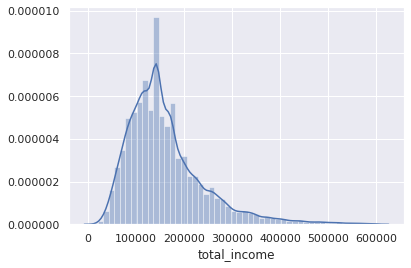

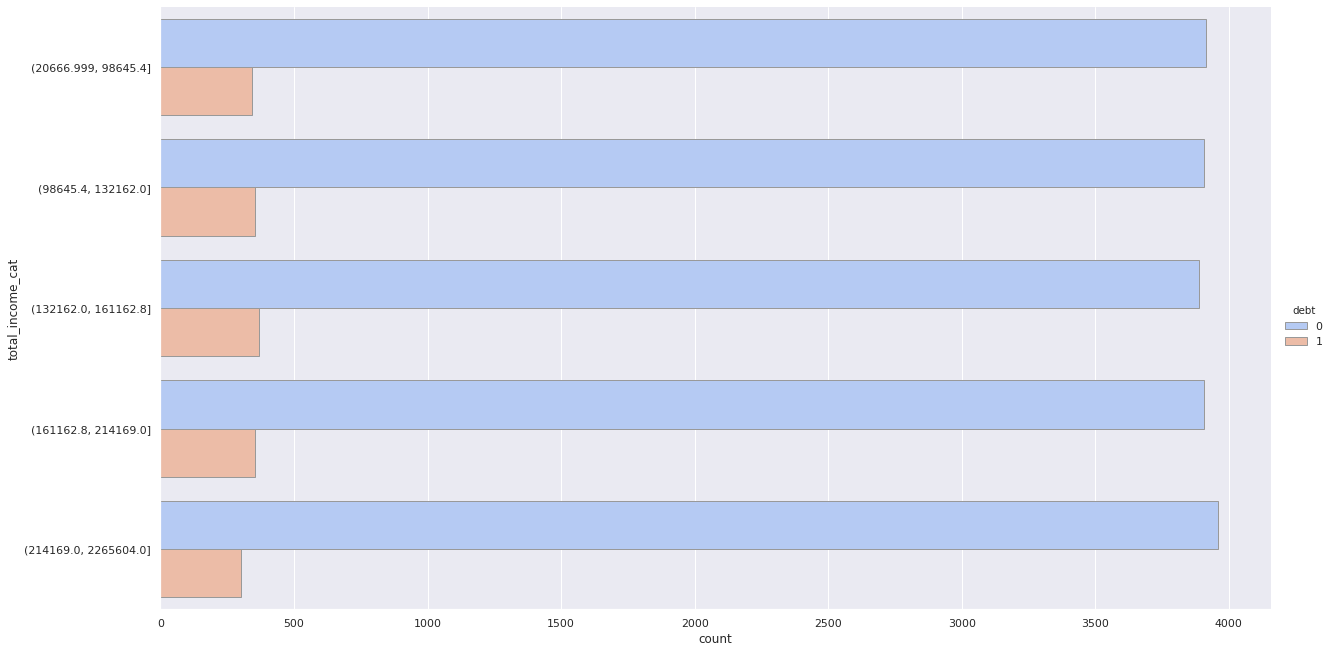

In [116]:
sns.distplot(df.query('total_income<600000')['total_income'])
print(df['total_income'].describe())
df['total_income_cat'] = pd.qcut(df['total_income'], 5)
df['total_income_cat'].unique()
sns.set()
sns.catplot(y="total_income_cat", hue="debt",palette='coolwarm', \
            kind="count",edgecolor=".6",height=9,data=df, aspect=2)

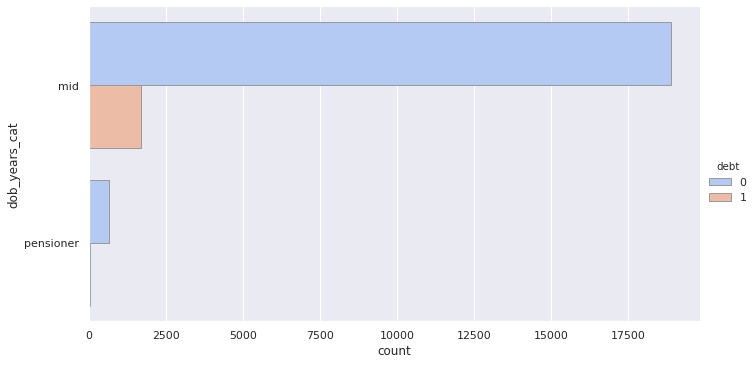

In [117]:
def years_cat(data):
        if (data < 18):
            return 'young'
        elif (18<= data <=65):
            return 'mid'
        else: 
            return 'pensioner'
df['dob_years_cat'] = df['dob_years'].apply(years_cat)
sns.catplot(y='dob_years_cat',data=df, hue="debt",palette='coolwarm', \
            kind="count",edgecolor=".6",height=5, aspect=2)

**Вывод**

Добавлены столбцы с категориями по возрасту (молодежь, пенсионер, средний возраст) и по заработку.
Категоризация доходов выполнена по квантилям на 5 частей.

## 3. Ответы на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [118]:
df1 = df.query('debt==1').groupby('children')['children'].count()
df2 = df.query('debt==0').groupby('children')['children'].count()
df_childrens = pd.concat([df1, df2], axis=1)
df_childrens.set_axis(['debt_1','debt_0'],axis='columns',inplace=True)
df_childrens['ratio'] = df_childrens['debt_1']/df_childrens.sum(axis=1)
display(df_childrens.sort_values(by='ratio', ascending=False).reset_index())

,children,debt_1,debt_0,ratio
0,4,4.0,37,0.097561
1,2,194.0,1848,0.095005
2,1,441.0,4361,0.091837
3,3,27.0,301,0.082317
4,0,1058.0,13017,0.075169
5,5,NaN,9,NaN


In [119]:
table = pd.pivot_table(df, values='debt', index='children', \
                       aggfunc=[np.sum, 'count']).reset_index()
table['ratio'] = table['sum']/table['count']
table.sort_values(by='ratio', ascending=False).reset_index()

,index,children,sum,count,ratio
,,,debt,debt,
0,4,4,4,41,0.097561
1,2,2,194,2042,0.095005
2,1,1,441,4802,0.091837
3,3,3,27,328,0.082317
4,0,0,1058,14075,0.075169
5,5,5,0,9,0.000000


**Вывод**

Согласно данным клиенты с тремя детьми и без детей - более надежные заемщики.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [120]:
df1 = df.query('debt==1').groupby('family_status_id')['family_status_id'].count()
df2 = df.query('debt==0').groupby('family_status_id')['family_status_id'].count()
df_family = pd.concat([df1, df2], axis=1)
df_family.set_axis(['debt_1','debt_0'],axis='columns',inplace=True)
df_family['ratio'] = df_family['debt_1']/df_family.sum(axis=1)
display(df_family.sort_values(by='ratio', ascending=False).reset_index())

,family_status_id,debt_1,debt_0,ratio
0,4,272,2509,0.097807
1,1,383,3756,0.092534
2,0,923,11329,0.075335
3,3,84,1094,0.071307
4,2,62,885,0.065470


**Вывод**

Согласно данным вдовцы и клиенты в разводе - более надежные заемщики.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [121]:
df1 = df.query('debt==1').groupby('total_income_cat')['total_income_cat'].count()
df2 = df.query('debt==0').groupby('total_income_cat')['total_income_cat'].count()
df_income = pd.concat([df1, df2], axis=1)
df_income.set_axis(['debt_1','debt_0'],axis='columns',inplace=True)
df_income['ratio'] = df_income['debt_1']/df_income.sum(axis=1)
display(df_income.sort_values(by='ratio',ascending=False).reset_index())
print(df['total_income'].describe())
print(f"Медиана: {df['total_income'].median()}")

,total_income_cat,debt_1,debt_0,ratio
0,"(132162.0, 161162.8]",370,3888,0.086895
1,"(98645.4, 132162.0]",355,3905,0.083333
2,"(161162.8, 214169.0]",354,3905,0.083118
3,"(20666.999, 98645.4]",344,3916,0.080751
4,"(214169.0, 2265604.0]",301,3959,0.070657


count    2.129700e+04
mean     1.653017e+05
std      9.828250e+04
min      2.066700e+04
25%      1.077890e+05
50%      1.425940e+05
75%      1.955490e+05
max      2.265604e+06
Name: total_income, dtype: float64
Медиана: 142594.0


**Вывод**

Клиенты с самым высоким доходом - более надежные клиенты. Причем со средним доходом - самая ненадежная.

- Как разные цели кредита влияют на его возврат в срок?

In [122]:
df1 = df.query('debt==1').groupby('purpose_lem')['purpose_lem'].count()
df2 = df.query('debt==0').groupby('purpose_lem')['purpose_lem'].count()
df_purpose = pd.concat([df1, df2], axis=1)
df_purpose.set_axis(['debt_1','debt_0'],axis='columns',inplace=True)
df_purpose['ratio'] = df_purpose['debt_1']/df_purpose.sum(axis=1)
display(df_purpose.sort_values(by='ratio',ascending=False).reset_index())

,purpose_lem,debt_1,debt_0,ratio
0,автомобиль,397,3869,0.093061
1,образование,369,3609,0.092760
2,свадьба,181,2142,0.077916
3,недвижимость,777,9953,0.072414


**Вывод**

Кредиты на недвижимость и празднование свадьбы самые надежные, на автомобили и образование самые ненадежные.

## 4. Общий вывод

В ходе работы была проведена подготовка данных к исследованию:
* Общий анализ данных
* Поиск и заполнение пропусков
* Замена типа данных
* Поиск и удаление дубликатов
* Лемматизация
* Категоризация данных

Далее был произведен аналитический поиск зависимостей с выплатой задолжностей:
* Наличие детей (клиенты с тремя детьми и без детей - самые надежные)
* Семейное положение (вдовцы и клиенты в разводе - более надежные заемщики)
* Уровнем дохода (клиенты с самым высоким доходом - самые надежные)
* Целей кредита (кредиты на недвижимость и празднование свадьбы самые надежные)

Установлены факторы влияющие на надежность клиента.
Более точный анализ требует проверки статистических гипотез и построение модели кредитного скоринга.